In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



## The Market-Cap Weighted strategy



* most important quantitative strategy.

* start with a vector of market capitalization for all relevant assets $M_t=[m_t^{AAPL},m_t^{GOOG},m_t^{TSLA},..]$ 

$$m_t^{AAPL}=P^{AAPL}_t\times SharesOutstanding^{AAPL}$$

The strategy then set the weights simply to 

$$X_t=\frac{M_t}{\sum_i^Im^i_t}$$

So at end of month **t** you look at the market caps, construct the weights, and buy the assets with weights $X_t$ to earn

$$R^{mcap}_{t+1}=X_tR_{t+1}$$

at the end of the next month.

This portfolio has nice properties


1. This portfolio is very easy to trade. It does not require re-balancing as you weights naturally go up if the stock rallies and go down if the stock crashes
  
2. You can implement this approach to any subset of firms (for example SP500 or Russel2000) are market cap indexes that track a particular universe of stocks

3. By buying proportionally to market cap you never have to build a huge position in a tiny stock

1. IF implemented for ALL assets, the CAPM says that this portfolios should be MVE. In practice we never do across all assets, but it should at least be much closer to MVE  then a portfolio made of a just a few stocks

Below we will construct the market portfolio for the US equity market.

But we use this type of code to many trading strategies

- for example, momentum investing amounts to make market cap weights on stocks that have been doing well (in terms of relative returns) in the last 12 month.

**Steps**

1. Get firm level monthly return data with market capitalizations
2. clean up/organize the data set
3. Make sure to lag the market cap signal so that we use prices from last month to trade at the start of this month ( we could also skip another month to be extra sure)
4. Construct the weighted average of returns across stocks for each date

**Download data from WRDS**

You will be required to put your name and password if you have it


**Organizing the data**

The objective here is to have a data set with 

- Security identifier
- Date of the information
- Monthly return of the firm in that month
- Market capitalization of the firm in that month

**Note**

In this data set negative price mean that there was not trade in the last trading day of the month of the particular stock. So the value is the negative of the mid point in these date

price if no trade=$-\frac{Ask+Bid}{2}$

So we either drop those observations or simply take the absolute value, which is simply using the mid point to compute the market cap

Using Mid point is completely fine here. It would be more problematic if that was determining the prices that we trade.

In [ ]:
import datetime as dt
import wrds
import psycopg2 
from dateutil.relativedelta import *
from pandas.tseries.offsets import *
###################
# Connect to WRDS. #
# You will be required to put your name and password if you have it
###################
conn=wrds.Connection() 

###################
# This below dowloads from the server the data that we want #
###################
crsp_m = conn.raw_sql("""
                      select a.permno, a.date, b.shrcd, b.exchcd,
                      a.ret, a.shrout, a.prc,a.retx
                      from crsp.msf as a
                      left join crsp.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '01/01/2005' and '12/31/2020'
                      and b.exchcd between 1 and 3
                      and b.shrcd between 10 and 11
                      """, date_cols=['date']) 

# this saves it
#crsp_m.to_pickle('../../assets/data/crspm2005_2020.pkl')
# variables downloaded

# 1. Permno-- are unique indentifier to a security 
# (for exmaple a stock that has multiple types of stocks will have multiple permnos)

# 2. shrco is the type of share: common share, ADR, ETF, ....
# we will focus on common shares

# 3. exchcd is the code of the exchange where the stock was originally listed
# we will focus on stock listed in the 3 major stock exchanges ( basically the whole market)

# 4. ret,retx, shrout,  prc, are the stock return, the stock return excluding dividends, number of shares outstanding, and price

# 5. date is the trading date of the return



Enter your WRDS username [Alan.Moreira]: moreira5
Enter your password: ···········


WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done


____
*If you don't want to deal with that you can simply get the data by running the code below*

In [ ]:

crsp_m=pd.read_pickle('https://github.com/amoreira2/Lectures/blob/main/assets/data/crspm2005_2020.pkl?raw=true')

In [71]:

crsp=crsp_m[['permno','date','ret','shrout','prc']].copy()
# change variable format to int
crsp[['permno']]=crsp[['permno']].astype(int)
# Line up date to be end of month 
crsp['date']=crsp['date']+MonthEnd(0)

# calculate market equity
# why do we use absolute value of price?
crsp['me']=crsp['prc'].abs()*crsp['shrout'] 
# drop price and shareoustandng since we won't need it anymore
crsp=crsp.drop(['prc','shrout'], axis=1)



,permno,date,ret,me
0,11671,2005-01-31,0.016491,8.192548e+03
1,10001,2005-01-31,-0.040580,1.717890e+04
2,10002,2005-01-31,-0.132466,2.352984e+05
3,11674,2005-01-31,0.015766,7.621100e+06
4,11681,2005-01-31,0.337143,4.302792e+04
...,...,...,...,...
763621,81665,2020-08-31,-0.003570,8.317922e+05
763622,81666,2020-08-31,0.130362,6.181997e+05
763623,81677,2020-08-31,0.072037,1.266447e+07
763624,81678,2020-08-31,0.069919,5.741383e+06


**Lagging the market cap signal**

We use the method `.shift(d)` which "lags" the data by d periods.

- tT is critical that we have our data set sorted by date


`shift(d)` simply shifts the rows. So you have to make sure that it is actually lagging by date. 

The way to do that is to  `groupby` security and applying the shift within security.

>Why this is important?

Because the data set is stacked so when you shift the first month of security n, it will end up returning the last month of security n-1.

By grouping by we simply assign a missing value there since we don't have the data

In [ ]:
# sort by permno and date and set as index
crsp=crsp.sort_values(by=['permno','date'])

In [74]:
# done incorrectly
crsp['me_l1']=crsp.me.shift(1)
crsp.iloc[250:280]
# what is the problem  here?

,permno,date,ret,me,me_l1
9582,10012,2005-03-31,-0.080000,10916.720198,11866.000000
14335,10012,2005-04-30,-0.195652,8780.840113,10916.720198
18981,10012,2005-05-31,-0.243243,6648.600028,8780.840113
23732,10012,2005-06-30,-0.250000,4986.449844,6648.600028
30586,10012,2005-07-31,-0.190476,4036.650042,4986.449844
9,10025,2005-01-31,0.277966,159037.453218,4036.650042
4584,10025,2005-02-28,0.082228,172114.796782,159037.453218
9586,10025,2005-03-31,-0.031863,168270.000000,172114.796782
14336,10025,2005-04-30,-0.058734,158535.521301,168270.000000
18982,10025,2005-05-31,-0.073158,146954.666096,158535.521301


In [75]:

crsp['me_l1']=crsp.groupby(['permno']).me.shift(1)
crsp.iloc[250:280]
# did it get fixed?

,permno,date,ret,me,me_l1
9582,10012,2005-03-31,-0.080000,10916.720198,11866.000000
14335,10012,2005-04-30,-0.195652,8780.840113,10916.720198
18981,10012,2005-05-31,-0.243243,6648.600028,8780.840113
23732,10012,2005-06-30,-0.250000,4986.449844,6648.600028
30586,10012,2005-07-31,-0.190476,4036.650042,4986.449844
9,10025,2005-01-31,0.277966,159037.453218,NaN
4584,10025,2005-02-28,0.082228,172114.796782,159037.453218
9586,10025,2005-03-31,-0.031863,168270.000000,172114.796782
14336,10025,2005-04-30,-0.058734,158535.521301,168270.000000
18982,10025,2005-05-31,-0.073158,146954.666096,158535.521301


In [76]:
Rmkt=crsp.groupby(['date']).apply(lambda x:(x.ret*(x.me_l1/x.me_l1.sum())).sum())

So in the code above `(x.me/x.me.sum())` is the weights, which for each date will return a vector that adds up to one. and of course `x.ret` is the vector of returns

The code `(x.ret*(x.me/x.me.sum())` multiplies the return of each asset by the weight and then we sum if all up to get the reutrn of the portfolio

```(x.ret*(x.me/x.me.sum())).sum()```

The `groupby(['date'])` method groups the data by month so we obtain the return of the portfolio in that month



<AxesSubplot:xlabel='date'>

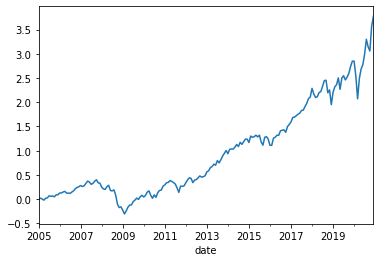

In [77]:
#Lets look at the cumulative returns
((Rmkt+1).cumprod()-1).plot()

**Things to try**

- Download the market factor from Kenfrench website. How correlated is our replication with his factor? Do they have similar mean and volatility in the same sample?
- Suppose you wanted to construct something "like" the SP500? I.e. do market cap weights but only form the 500 largest firms in a given month. How would you use groupby to do that?
- Suppose you lag 2 months instead of 1 does it make any difference?
- Suppose you drop the stocks with "negative" prices, does it make a difference?